# Computer vision and deep learning - Laboratory 5

In this laboratory, you will continue the semantic segmentation mini-project that we started last time. More specifically, you will write the CNN architecture, define the training loop, perform hyperparameter search and evaluate the best segmentation module.

In [1]:
!pip install wget
!pip install wandb -qU

import os
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir 'cvdl_lab_4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘cvdl_lab_4’: File exists


In [3]:
!cd cvdl_lab_4
!pwd

/content


## Building the model

The model that will be used in this laboratory is inspired by the [U-Net](https://arxiv.org/abs/1505.04597) architecture.
U-Net is a fully convolutional neural network comprising two symmetric paths: a contracting path (to capture context) and an expanding path  (which enables precise localization).
The network also uses skip connections between the corresponding layers in the downsampling path to the layer in the upsampling path, and thus directly fast-forwards high-resolution feature maps from the encoder to the decoder network.

The output of the model is an volume with depth C, where C is the number of pixel classes. For example, if you want to classify the pixels into person and background, the output will be a volume of depth 2.
If you want to classify the pixels into face, hair and background the output will be a volume of depth 3.

**Read the U-Net paper and try to understand the architecture.**

An overview of the U-Net architecture is depicted in the figure below:
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png"/>




## The downsampling path


For the downsampling path we'll use a convolutional neural network from the pretrained torchvision models.
We'll cover this in detail in the next laboratory session.


## The upsamping path


In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


In [4]:
def upsample_block(x, filters, size, stride = 2):
  """
  x - the input of the upsample block
  filters - the number of filters to be applied
  size - the size of the filters
  """

  # TODO your code here
  # transposed convolution
  x = torch.nn.ConvTranspose2d(in_channels=x.size(1), out_channels=filters, kernel_size=size, stride=stride)(x)

  # BN
  x = torch.nn.BatchNorm2d(num_features=filters)(x)

  # relu activation
  x = torch.nn.ReLU(inplace=True)(x)

  return x

Now let's test this upsampling block.
Change the parameters of of this function and notice how the shape of the output changes.

In [5]:
in_layer = torch.rand((32, 32, 128, 128))

filter_sz = 4
num_filters = 16

for stride in [2, 4, 8]:
  x = upsample_block(in_layer, num_filters, filter_sz, stride)
  print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_sz, '; stride ', stride, ' -> out shape ', x.shape)

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 258, 258])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 512, 512])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 1020, 1020])


In [6]:
class DoubleSamplingBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()

        if mid_channels is None:
            mid_channels = out_channels

        # sequential block with two convolutional layers
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=3),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=3),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )

    def forward(self, X):
        return self.double_conv(X)

## The down-sampling path


For the down-sampling path we'll use a classical convolutional neural network.

Write a class Encoder which inherits from ``torch.nn.Module`` for the down-sampling path. The model will be composed of several blocks, each block comprising two convolutional layers (with filter size of 3) with a ``ReLu`` non-linearity between them. The blocks of the encoder will be separated by max pooling layers with a size of 2 and a stride of 2.

 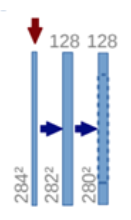

In the constructor of the Encoder class you will pass as parameter a list containing the number of channels used for each encoder block. In the forward function you will return a list containing the outputs of all the encoder blocks (you’ll be using them for the connection between the down-sampling path and the up-sampling path).

You can also use a pre-trained module from torchvision for this. You'll first load the pre-trained weights on ImageNet, and "freeze" these weights during the training process (set required_grad=False for those tensors). The problem is that to create the skip connections required by the U-Net architecture we need access to the feature maps of some intermediate layers in the network and these are not accessible by default.

You should inspect the implementation of the CNN that you chose, make the Encoder class inherit from the model you chose, and in the forward function, return the output of the layers you selected for the skip connections.



In [7]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.encoder = torch.nn.Sequential(
            # 2x2 max pooling at the beginning
            torch.nn.MaxPool2d(kernel_size=2),

            # 2 upsample blocks
            DoubleSamplingBlock(in_channels, out_channels=out_channels),
        )

    def forward(self, X):
        return self.encoder(X)

## The up-sampling path (Decoder)

In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


Similarly to the encoder, the decoder will be composed of several blocks, and each block will consist in a transposed convolution (followed by a batch normalization layer and a ReLU non-linearity) and then by an encoder block.  

 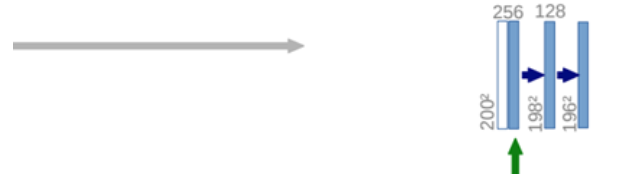

Write a class Decoder  which inherits from ``torch.nn.Module`` to implement the up-samping path; the constructor of this class will get as parameter the depth of each decoder module, and in the forward function you will have two parameters: the input feature map and a list of activations from the encoder (for the skip connections).  



In the forward function, for each block:

- apply the up-sampling operation (followed by batch normalization and ReLU);

- crop the corresponding activation map from the encoder (use CenterCrop) such that is has the same size as the decoder block;

- concatenate these two activation maps (on the channel dimension);

- apply an encoder block on the result;

- pass the result to the next decoder block.



In [8]:
def center_crop(original_image, target_image):
    # get dimensions of the original and target images
    original_height, original_width = original_image.shape[-2], original_image.shape[-1]
    target_height, target_width = target_image.shape[-2], target_image.shape[-1]

    # calculate starting indices for cropping
    start_height = max(0, (original_height - target_height) // 2)
    start_width = max(0, (original_width - target_width) // 2)

    # calculate ending indices for cropping
    end_height = start_height + target_height
    end_width = start_width + target_width

    # perform cropping
    cropped_image = original_image[..., start_height:end_height, start_width:end_width]

    return cropped_image

In [9]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels) -> None:
        super().__init__()

        self.up = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=input_channels,
                out_channels=input_channels // 2,
                kernel_size=2,
                stride=2,
                padding=0
            ),
            torch.nn.BatchNorm2d(input_channels // 2),
            torch.nn.ReLU(inplace=True),
        )
        self.sampling_block = DoubleSamplingBlock(
            in_channels=input_channels,
            out_channels=output_channels,
            mid_channels=input_channels // 2
        )

    def forward(self, encoder_features, X):
        X = self.up(X)

        # center crop the encoder features to match the input
        encoder_features = center_crop(encoder_features, X)

        # concatenate the encoder features and input along the channel dimension
        X = torch.cat([encoder_features, X], dim=1)

        # apply the sampling block
        X = self.sampling_block(X)

        return X

# Simpler implementation

Alternatively, you can choose to implement the entire architecture into a single class.

In the UNet diagram above, the arrows represent the layers in your network.
The blue rectangles represent the feature maps: the number on top of the rectangle is the number of channels of the feature map, while the numbers from the lower left is the spatial shape of the feature map (for example, $572 \times 572$ - is a feature map of height and width $572$)

```
class UNet(torch.nn.Module):
def __init__(num_classes):
    super().__init__()
    # TODO your code here create all the UNET layers
    # enc_11 -> the first convolutional layer from the first encoder block
    # the image is a color image, so the number of channels is 3, while according to the UNet architecture above, the number of output channels is 64
    self.enc_11 = torch.nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3)
    # enc_12 -> the second convolutional layer from the first encoder block
    # 64 input_channels (the input of enc_11 will be the output of enc_11 that has 64 filters),  
    self.enc_12 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
    # etc etc
   
```

## Putting it all together

Finally, you should write the UNet class which defines the semantic segmentation model. In this class you will use and connect the Encoder and Decoder classes that you previously wrote. The output of the segmentation module will be a volume with as many channels as the number of classes from the segmentation problem. Basically, each channel c from the output will be a map that stores the probability of each pixel to belong to the class c.

Apply a 1x1 convolution with c channels on the decoder output to obtain the segmentation map.

Finally, to have matching shapes between the network output (segmentation map) and the ground truth data, resize the segmentation map using ``torch.nn.functional.interpolate``.


### The training loop


Now, it’s time to write the training loop.  

You remember the steps from the previous labs. You need a train and a test DataLoader and you must first define the loss function cross entropy and select an optimizer.

Then:

- Get a batch of training data from the DataLoader
- Zero out the optimizer’s gradients
- Perform the forward pass
- Calculate and store the loss and the accuracy based on the predictions and the labels from the dataset
- Tell the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
- Evaluate the model on the validation/test set. Store the loss and the accuracy on the validation/test set.

In [10]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes, intermediary_filters=64, num_layers=4):
        super().__init__()

        # initial convolution block
        self.in_convolution = DoubleSamplingBlock(
            in_channels=in_channels,
            out_channels=intermediary_filters,
            mid_channels=64
        )

        # list of encoder blocks
        self.encoders = torch.nn.ModuleList([
            EncoderBlock(
                in_channels=intermediary_filters * 2**i,
                out_channels=2 * intermediary_filters * 2**i
            ) for i in range(num_layers)
        ])

        # list of decoder blocks
        self.decoders = torch.nn.ModuleList([
            DecoderBlock(
                input_channels=2 * intermediary_filters * 2**i,
                output_channels=intermediary_filters * 2**i
            ) for i in range(num_layers)
        ])

        # output convolution layer
        self.out_convolution = torch.nn.Conv2d(
            in_channels=intermediary_filters,
            out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, X):
        X = self.in_convolution(X)

        # list to store intermediate outputs from each encoder block
        outputs = [X]

        # forward pass through encoder blocks
        for i, encoder in enumerate(self.encoders):
            outputs.append(encoder.forward(outputs[i]))

        # get the output from the last encoder block
        X = outputs[-1]

        # forward pass through decoder blocks in reverse order
        for i, decoder in enumerate(self.decoders[::-1]):
            X = decoder.forward(outputs[len(self.decoders) - 1 - i], X)

        # apply the final output convolution layer
        X = self.out_convolution(X)

        return X

## Evaluation metrics

Finally, you will implement several segmentation metrics to evaluate the model you've just trained. As usual, try to implement these metrics without using any for loops.

In the remainder of this section we'll use the following notation:
- $n_{ij}$ - the total number of pixels classified to class
j but actually belonging to class i; $i, j \in 1, .., C$;
- $t_i = \sum_{j = 1}^{C} n_{ij}$ - the total number of pixels belonging to class $i$ (in the ground truth segmentation mask);
- $C$ - the total number of classes in the segmentation problem.

### Mean pixel accuracy

Pixel accuracy is the simplest image segmentation metric; it is defined as the percentage of pixels that were correctly classified by the model.

\begin{equation}
p_a = \frac{1}{C} \frac{\sum_{i}^{C} n_{ii}}{\sum_{i}^{C} t_i}
\end{equation}

This metric is not that relevant for class imbalanced problems (which occurs for most segmentation problems).

### Intersection over Union (IoU)

the intersection over union metric is defined as the ratio between the area of intersection and the area of union (between the predicted segmentation mask and the ground truth segmentation mask of a single class).
In case of a multi-class segmentation problem, we simple average the IoUs over all the classes. This metric is called mean Intersection over Union (mIou).

\begin{equation}
mIoU = \frac{1}{C} \sum_{i = 1}^{C} \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The ideal value for this metric is 1; usually values lower than 0.6 indicate a very bad performance.

### Frequency Weighted Intersection over Union

The frequency weighted over union metric is similar to mean IoU, but the values are weighted with the adequate frequencies of the pixels.

\begin{equation}
fIou = (\sum_{i = 1}^{k} t_i)^{-1}   \sum_{i = 1}^{C} t_i \cdot \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The values of this metric lie in the interval [0, 1], and the ideal value for this metric is 1.

Compute and report these metrics for your trained model(s).



In [11]:
import requests
import hashlib
import tarfile

from tqdm import tqdm
from PIL import Image

class LFWDataset(torch.utils.data.Dataset):
    _DATA = (
        # images
        ("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", None),
        # segmentation masks as ppm
        ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz",
         "3e7e26e801c3081d651c8c2ef3c45cfc"),
    )

    _SPLIT_NAMES = {
        "train": "https://vis-www.cs.umass.edu/lfw/part_labels/parts_train.txt",
        "validation": "https://vis-www.cs.umass.edu/lfw/part_labels/parts_validation.txt",
        "test": "https://vis-www.cs.umass.edu/lfw/part_labels/parts_test.txt"
    }

    def __init__(self, base_folder, transforms, download=True, split_name: str = 'train'):
        super().__init__()
        self.base_folder = base_folder
        self.transforms = transforms

        if download:
            self.download_resources(base_folder)

        self.X = []
        self.Y = []

        with open(f"{base_folder}/parts_{split_name}.txt") as f:
            for line in f:
                name = line.split(" ")[0]
                number = ("%04d" % int(line.split(" ")[1]))
                raw_file_path = f"{base_folder}/lfw_funneled/{name}/{name}_{number}.jpg"
                feature_file_path = f"{base_folder}/parts_lfw_funneled_gt_images/{name}_{number}.ppm"

                self.X.append(cv2.cvtColor(cv2.imread(raw_file_path), cv2.COLOR_BGR2RGB))
                self.Y.append(cv2.cvtColor(np.array(Image.open(feature_file_path)), cv2.COLOR_RGB2BGR))

                if self.transforms is not None :
                    self.X[-1], self.Y[-1] = self.transforms(self.X[-1], self.Y[-1])

        print(f"Number of images: {len(self.X)}")
        print(f"Number of masks: {len(self.Y)}")

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def download_resources(self, base_folder):
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        self._download_and_extract_archive(url=LFWDataset._DATA[1][0], base_folder=base_folder,
                                           md5=LFWDataset._DATA[1][1])
        self._download_and_extract_archive(url=LFWDataset._DATA[0][0], base_folder=base_folder, md5=None)

        self._download_url(url=LFWDataset._SPLIT_NAMES['train'], base_folder=base_folder, md5=None)
        self._download_url(url=LFWDataset._SPLIT_NAMES['validation'], base_folder=base_folder, md5=None)
        self._download_url(url=LFWDataset._SPLIT_NAMES['test'], base_folder=base_folder, md5=None)

    def _download_and_extract_archive(self, url, base_folder, md5) -> None:
        """
          Downloads an archive file from a given URL, saves it to the specified base folder,
          and then extracts its contents to the base folder.

          Args:
          - url (str): The URL from which the archive file needs to be downloaded.
          - base_folder (str): The path where the downloaded archive file will be saved and extracted.
          - md5 (str): The MD5 checksum of the expected archive file for validation.
          """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)

        self._download_url(url, base_folder, md5)
        archive = os.path.join(base_folder, filename)
        print(f"Extracting {archive} to {base_folder}")
        self._extract_tar_archive(archive, base_folder, True)

    def _retreive(self, url, save_location, chunk_size: int = 1024 * 32) -> None:
        """
            Downloads a file from a given URL and saves it to the specified location.

            Args:
            - url (str): The URL from which the file needs to be downloaded.
            - save_location (str): The path where the downloaded file will be saved.
            - chunk_size (int, optional): The size of each chunk of data to be downloaded. Defaults to 32 KB.
            """
        try:
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))

            with open(save_location, 'wb') as file, tqdm(
                    desc=os.path.basename(save_location),
                    total=total_size,
                    unit='B',
                    unit_scale=True,
                    unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    bar.update(len(data))

            print(f"Download successful. File saved to: {save_location}")

        except Exception as e:
            print(f"An error occurred: {str(e)}")

    def _download_url(self, url: str, base_folder: str, md5: str = None) -> None:
        """Downloads the file from the url to the specified folder

        Args:
            url (str): URL to download file from
            base_folder (str): Directory to place downloaded file in
            md5 (str, optional): MD5 checksum of the download. If None, do not check
        """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)
        file_path = os.path.join(base_folder, filename)

        os.makedirs(base_folder, exist_ok=True)

        # check if the file already exists
        if self._check_file(file_path, md5):
            print(f"File {file_path} already exists. Using that version")
            return

        print(f"Downloading {url} to file_path")
        self._retreive(url, file_path)

        # check integrity of downloaded file
        if not self._check_file(file_path, md5):
            raise RuntimeError("File not found or corrupted.")

    def _extract_tar_archive(self, from_path: str, to_path: str = None, remove_finished: bool = False) -> str:
        """Extract a tar archive.

        Args:
            from_path (str): Path to the file to be extracted.
            to_path (str): Path to the directory the file will be extracted to. If omitted, the directory of the file is
                used.
            remove_finished (bool): If True , remove the file after the extraction.
        Returns:
            (str): Path to the directory the file was extracted to.
        """
        if to_path is None:
            to_path = os.path.dirname(from_path)

        with tarfile.open(from_path, "r") as tar:
            tar.extractall(to_path)

        if remove_finished:
            os.remove(from_path)

        return to_path

    def _compute_md5(self, filepath: str, chunk_size: int = 1024 * 1024) -> str:
        with open(filepath, "rb") as f:
            md5 = hashlib.md5()
            while chunk := f.read(chunk_size):
                md5.update(chunk)
        return md5.hexdigest()

    def _check_file(self, filepath: str, md5: str) -> bool:
        if not os.path.isfile(filepath):
            return False
        if md5 is None:
            return True
        return self._compute_md5(filepath) == md5

    def __len__(self):
        # return the total number of samples in the dataset
        return len(self.X)

In [12]:
from torch.utils.data.dataloader import DataLoader

def transform_generator(INPUT_SHAPE):
  def transform(X, y):
      with torch.no_grad():
          if X is not None:
              # transpose channels to PyTorch format (C, H, W)
              X = X.transpose([2, 0, 1])
              # convert to PyTorch tensor
              X = torch.from_numpy(X)
              X = X.to(torch.float32)
              # normalize pixel values to the range [0, 1]
              X = X / 255
              # resize image to the desired input shape
              X = torch.nn.functional.interpolate(X.view(-1, *X.shape), size=INPUT_SHAPE).view(-1, *INPUT_SHAPE)
          if y is not None:
              # transpose channels to PyTorch format (C, H, W)
              y = y.transpose([2, 0, 1])
              # convert to PyTorch tensor
              y = torch.from_numpy(y)
              # convert one-hot encoded label to categorical label
              y = torch.argmax(y, dim=0, keepdim=True)
              y = y.to(torch.float32)
              # resize label to the desired input shape using nearest-neighbor interpolation
              y = torch.nn.functional.interpolate(y.view(1, *y.shape), size=INPUT_SHAPE, mode='nearest').view(*INPUT_SHAPE)
              y = y.to(torch.int64)
      return X, y
  return transform

BASE_PATH="./lfw_dataset"

batch_size = 64

train_dataset = LFWDataset(BASE_PATH, download=False, split_name='train', transforms=transform_generator((128, 128)))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = LFWDataset(BASE_PATH, download=False, split_name='validation', transforms=transform_generator((128, 128)))
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

Number of images: 1500
Number of masks: 1500
Number of images: 500
Number of masks: 500


# Wandb


This time you will use [wandb](https://wandb.ai/) to track your experiments and perform hyperparameter search.


1. Log the loss and several metrics after each epoch: use ``wandb.log()`` method within your training loop after each epoch to log the loss and at least two metrics on the train and the validation dataset.


2. Use a ``wandb.Table`` to visualize the predictions on the validation dataset across the training process. You can find more details [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/datasets-predictions/W%26B_Tables_Quickstart.ipynb#scrollTo=tbOiat0mrWA2).


3. [Artifacts](https://docs.wandb.ai/guides/artifacts/construct-an-artifact) are used to track and version any serialized data as the inputs and outputs.


"W&B Artifacts was designed to make it effortless to version your datasets and models, regardless of whether you want to store your files with W&B or whether you already have a bucket you want W&B to track. Once you've tracked your datasets or model files, W&B will automatically log each and every modification, giving you a complete and auditable history of changes to your files."


Create a class ModelCheckpoint which will be responsible for tracking the best N checkpoints across the training process. This class will monitor a metric, and if the value for that metric is higher/lower (depending on whether the ) than the current max/min, it will save a checkpoint of the model.
Also, you should ensure that at a given time only N checkpoints are being saved. So, if the number of saved checkpoints is greater than N, you should perform a cleanup.


```
    def __call__(self, model, epoch, metric_val):
        must_save = metric_val < self.best_metric_val if self.decreasing_metric else metric_val > self.best_metric_val
        if must_save:
            self.best_metric_val = metric_val
            # TODO use torch.save to save the model
            # TODO use the function below to log the model artifact
       
        # TODO if needed, perform cleanup
   
    def write_artifact(self, path, model_path, metric_val):
        artifact = wandb.Artifact(filename, type='model', metadata={'metric': metric_val})
        artifact.add_file(model_path)
        wandb.run.log_artifact(artifact)    


```


4. You will also use [wandb sweeps](https://docs.wandb.ai/guides/sweeps) to automate hyperparameter tuning. This module explores different combinations of hyperparameters to help users find the best configuration for their models.

[Here](https://www.youtube.com/watch?v=9zrmUIlScdY&ab_channel=Weights%26Biases) you can find a video tutorial on how you can use sweeps in wandb and [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb) the corresponding colab.


Random Search is a hyperparameter optimization technique that involves randomly sampling hyperparameter values within specified ranges or distributions. It explores the hyperparameter space by selecting combinations randomly, allowing for a broad search across various configurations without following a specific pattern or grid.


Grid Search is a method where hyperparameter values are exhaustively tested across a predefined grid or set of values. It evaluates the model's performance for each combination of hyperparameters within the specified ranges, systematically covering the entire search space to find the optimal configuration.


Perform hyperparameter search using wandb sweeps (more details [here](https://wandb.ai/wandb_fc/articles/reports/Running-Hyperparameter-Sweeps-to-Pick-the-Best-Model--Vmlldzo1NDQ0OTIy)) for the learning rate and at least one other parameter.
- first perform a random search as a preliminary exploration to identify "promising" values for your hyperparameters;
- then apply a grid search on this range, to perform a more focused investigation into promising regions for finer optimization.



In [13]:
class ModelCheckpoint:
    def __init__(self, metric_name, is_decreasing_metric, keep = 3):
        self.best_metric_value = None
        self.metric_name = metric_name
        self.is_decreasing_metric = is_decreasing_metric
        self.keep = keep
        self.saved_checkpoints = []

    def __call__(self, model, epoch, metric_value):
        should_save = self.best_metric_value is None or (
            metric_value < self.best_metric_value if self.is_decreasing_metric else metric_value > self.best_metric_value
        )

        if should_save:
            self.best_metric_value = metric_value
            torch.save(model, f"./artifacts/model_save_{self.metric_name}_{metric_value}")
            self.saved_checkpoints.append((f"./artifacts/model_save_{self.metric_name}_{metric_value}", metric_value))

        while len(self.saved_checkpoints) > self.keep:
            os.remove(self.saved_checkpoints[0][0])
            self.saved_checkpoints = self.saved_checkpoints[1:]

    def __del__(self):
        for save in self.saved_checkpoints:
            self.write_artifact(save[0], save[1])
            os.remove(save[0])

    def write_artifact(self, model_path, metric_value):
        artifact_name = f"model_{self.metric_name}"
        artifact = wandb.Artifact(artifact_name, type='model', metadata={'metric': self.metric_name, 'metric_value': metric_value})
        artifact.add_file(model_path)

        wandb.run.log_artifact(artifact)
        artifact.wait()

In [14]:
def apply_inverse_transform(image, label):
    with torch.no_grad():
        if label is not None:
            # convert label to one-hot encoding and scale
            label = torch.nn.functional.one_hot(label, num_classes=3) * torch.tensor(255)
            label = label.to(torch.uint8)
            label = label.cpu().numpy()

        if image is not None:
            # scale image values and transpose
            image = image * 255
            image = image.to(torch.uint8)
            image = image.cpu().numpy()
            image = image.transpose([1, 2, 0])

    return image, label


def calculate_belonging_data(model, dataloader):
    model.eval()
    total_belonging = None

    for images, labels in dataloader:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        images, labels = images.to(device), labels.to(device)
        model_predictions = model(images)
        # shape (batch, height, width)
        model_predictions = model_predictions.argmax(dim=1)
        # class (batch, height, width, class)
        model_predictions = torch.nn.functional.one_hot(model_predictions, num_classes=3).float()
        model_predictions = torch.nn.functional.interpolate(model_predictions.view(-1, *model_predictions.shape),
                                                            size=(*labels.shape[1:], 3), mode='nearest').view(*labels.shape, 3)
        model_predictions = model_predictions.long()

        ground_truth_one_hot = torch.nn.functional.one_hot(labels, num_classes=3)

        # shape(batch, height, width, class)
        model_predictions = model_predictions.cpu()
        # shape (batch, height, width, class)
        ground_truth_one_hot = ground_truth_one_hot.cpu()

        model_predictions_shape_list = list(model_predictions.shape)
        # shape (batch, heigh, width, 1, class)
        model_predictions_shape_list.insert(-1, 1)

        # (batch, row, col, ground_class, model_class)
        belonging_data = ground_truth_one_hot.view(*ground_truth_one_hot.shape, 1) @ model_predictions.view(
            model_predictions_shape_list)
        belonging_data = belonging_data.sum(dim=1)
        belonging_data = belonging_data.sum(dim=1)
        belonging_data = belonging_data.sum(dim=0)

        if total_belonging is None:
            total_belonging = belonging_data.cpu()
        else:
            total_belonging += belonging_data.cpu()

    return total_belonging


def evaluate_model(model, dataloader):
    model.eval()

    belongind_data = calculate_belonging_data(model, dataloader)
    ground_truth_data = torch.sum(belongind_data, dim=1)
    correctly_labeled_data = torch.diagonal(belongind_data)

    mean_pixel_accuracy = torch.mean(correctly_labeled_data / ground_truth_data)
    mean_iou = torch.mean(
        correctly_labeled_data / (ground_truth_data - correctly_labeled_data + torch.sum(belongind_data, dim=0)))
    weighted_iou = torch.sum(ground_truth_data * (correctly_labeled_data / (
            ground_truth_data - correctly_labeled_data + torch.sum(belongind_data, dim=0)))) / torch.sum(
        ground_truth_data)

    evaluation_metrics = {
        'mean_pixel_accuracy': mean_pixel_accuracy,
        'mean_iou': mean_iou,
        'weighted_iou': weighted_iou
    }

    return evaluation_metrics

In [15]:
import os

ARTIFACTS_PATH='./artifacts'
os.makedirs(ARTIFACTS_PATH, exist_ok=True)

In [20]:
import wandb

number_of_epochs = 50
learning_rate = 0.007

def train(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_function = torch.nn.CrossEntropyLoss()

    metrics = {
        'train': {
            'loss': [],
        },
        'validation': {
            'loss': [],
            'accuracy': [],
        }
    }

    checkpoints = {
        'validation_loss': ModelCheckpoint('validation_loss', is_decreasing_metric=True, keep=1),
        'mean_pixel_accuracy': ModelCheckpoint('mean_pixel_accuracy', is_decreasing_metric=False, keep=1),
        'mean_iou': ModelCheckpoint('mean_iou', is_decreasing_metric=False, keep=1),
        'weighted_iou': ModelCheckpoint('weighted_iou', is_decreasing_metric=False, keep=1),
    }

    for epoch in range(number_of_epochs):
        # initialize total training loss for the epoch
        total_train_loss = 0
        model.train()

        # iterate over training data batches
        for X, y in train_dataloader:
            optim.zero_grad()

            X, y = X.to(device), y.to(device)

            # forward pass
            predicted_labels = model(X)
            predicted_labels = torch.nn.functional.interpolate(predicted_labels, size=tuple(y.shape[1:]))

            # compute the training loss
            loss = loss_function(predicted_labels, y)

            # backward pass and optimization step
            loss.backward()
            optim.step()

            total_train_loss += loss.item()

        total_validation_loss = 0
        model.eval()

        columns = ["source_image", "predicted_image", "ground_truth"]
        predictions_table = wandb.Table(columns=columns)

        # iterate over validation data batches
        for X, y in validation_dataloader:
            X, y = X.to(device), y.to(device)

            # forward pass
            predicted_labels = model(X)
            predicted_labels = torch.nn.functional.interpolate(predicted_labels, size=tuple(y.shape[1:]))

            # compute the validation loss
            loss = loss_function(predicted_labels, y)
            total_validation_loss += loss.item()
            predicted_labels = predicted_labels.argmax(dim=1)

            # get the predicted labels and apply inverse transform for visualization
            for (source_image, prediction_image, ground_truth) in zip(X, predicted_labels, y):
                _, predicted_labels = apply_inverse_transform(source_image, prediction_image)
                X, y = apply_inverse_transform(source_image, ground_truth)
                predictions_table.add_data(wandb.Image(X), wandb.Image(predicted_labels), wandb.Image(y))

        # calculate average training and validation losses
        average_train_loss = total_train_loss / len(train_dataloader)
        average_validation_loss = total_validation_loss / len(validation_dataloader)

        # update the losses dictionary
        metrics['train']['loss'].append(average_train_loss)
        metrics['validation']['loss'].append(average_validation_loss)

        # evaluate the model on validation data
        with torch.no_grad():
            model_eval = evaluate_model(model, validation_dataloader)

        metrics['validation']['accuracy'].append(model_eval['mean_pixel_accuracy'])

        log_data = {
            'train_loss': average_train_loss,
            'validation_loss': average_validation_loss,
            'mean_pixel_accuracy': model_eval['mean_pixel_accuracy'],
            'mean_iou': model_eval['mean_iou'],
            'weighted_iou': model_eval['weighted_iou'],
            'predictions_table': predictions_table
        }

        # remove predictions_table from logging after the last epoch
        if epoch + 1 < number_of_epochs:
            del log_data['predictions_table']

        # log data to WandB
        wandb.log(log_data)

        # save checkpoints for metrics
        for k in checkpoints.keys():
            checkpoints[k](model, epoch, log_data[k])

        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_validation_loss:.4f}")

    return model, metrics

In [21]:
model = UNet(in_channels=3, num_layers=2, num_classes=3, intermediary_filters=32)

wandb.login(timeout=300)
wandb.init()

model, train_validation_metrics = train(model)

wandb.finish()

Epoch [1/50], Train Loss: 0.6632, Validation Loss: 2.8518
Epoch [2/50], Train Loss: 0.4717, Validation Loss: 0.6321
Epoch [3/50], Train Loss: 0.4371, Validation Loss: 0.4599
Epoch [4/50], Train Loss: 0.4163, Validation Loss: 0.6195
Epoch [5/50], Train Loss: 0.4054, Validation Loss: 0.6843
Epoch [6/50], Train Loss: 0.3834, Validation Loss: 0.4228
Epoch [7/50], Train Loss: 0.3637, Validation Loss: 0.5856
Epoch [8/50], Train Loss: 0.3617, Validation Loss: 0.4955
Epoch [9/50], Train Loss: 0.3422, Validation Loss: 0.3856
Epoch [10/50], Train Loss: 0.3183, Validation Loss: 0.4041
Epoch [11/50], Train Loss: 0.2943, Validation Loss: 0.3446
Epoch [12/50], Train Loss: 0.2852, Validation Loss: 0.4647
Epoch [13/50], Train Loss: 0.2770, Validation Loss: 0.3109
Epoch [14/50], Train Loss: 0.2588, Validation Loss: 0.3538
Epoch [15/50], Train Loss: 0.2527, Validation Loss: 0.2655
Epoch [16/50], Train Loss: 0.2347, Validation Loss: 0.2653
Epoch [17/50], Train Loss: 0.2254, Validation Loss: 0.2586
Epoch 

wandb: Waiting for artifact model_validation_loss to be committed...



wandb: Committed artifact trutadan-personal/uncategorized/model_validation_loss:v7
wandb: Waiting for artifact model_mean_pixel_accuracy to be committed...

wandb: Committed artifact trutadan-personal/uncategorized/model_mean_pixel_accuracy:v8
wandb: Waiting for artifact model_mean_iou to be committed...

wandb: Committed artifact trutadan-personal/uncategorized/model_mean_iou:v7
wandb: Waiting for artifact model_weighted_iou to be committed...

wandb: Committed artifact trutadan-personal/uncategorized/model_weighted_iou:v7


mean_iou,▁▃▅▄▆▄▅▆▆▅▆▆▇▇▇▇▇█▇▇▇█▇█████████████████
mean_pixel_accuracy,▁▂▄▂▆▃▃▆▅▄▆▆▇▇▆█▇▇▇▇▇█▇█▇███▇██▇████████
train_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weighted_iou,▁▅▆▅▆▅▆▇▇▆▇▇▇▇▇▇████████████████████████
mean_iou,0.797
mean_pixel_accuracy,0.87257
train_loss,0.08905
validation_loss,0.20822
weighted_iou,0.87417


In [29]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train']['loss']) + 1)

    # Plot training and validation losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train']['loss'], label='Training Loss')
    plt.plot(epochs, metrics['validation']['loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['validation']['accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

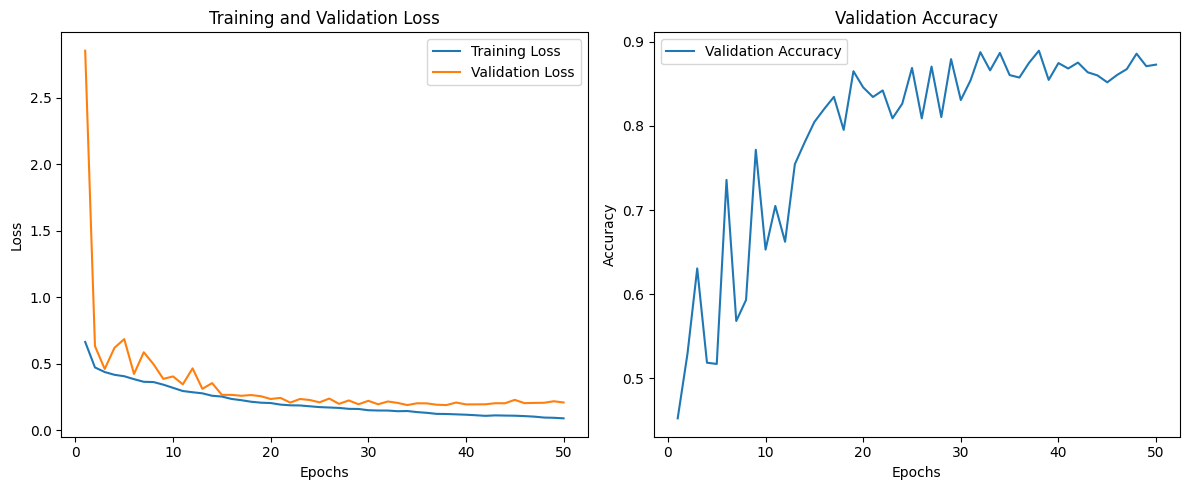

In [30]:
plot_metrics(train_validation_metrics)

In [24]:
test_dataset = LFWDataset(BASE_PATH, download=False, split_name='test', transforms=transform_generator((128, 128)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Number of images: 927
Number of masks: 927


In [25]:
def test(model, dataloader):
    model.eval()

    correct_predictions = 0
    total_samples = 0
    total_loss = 0

    loss_function = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # forward pass
            predicted_labels = model(X)
            predicted_labels = torch.nn.functional.interpolate(predicted_labels, size=tuple(y.shape[1:]))

            # compute loss
            loss = loss_function(predicted_labels, y)
            total_loss += loss.item()

        # compute accuracy using evaluate_model after iterating through the entire dataset
        accuracy = evaluate_model(model, dataloader)['mean_pixel_accuracy']
        average_loss = total_loss / len(dataloader)

    return accuracy, average_loss

In [26]:
test_accuracy, test_loss = test(model, test_dataloader)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8742
Test Loss: 0.2079


In [27]:
import pickle

# save the model for the gradio
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)